In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [2]:
try:
    x_train = pd.read_csv("x_train.csv", dtype={"ID": "int"})
except:
    print("Please first run 1_preprocess.ipynb!")
x_train.rename(columns={"Unnamed: 0": "Hour"}, inplace=True)

The maximum ICU hour of the patients has a large variance. It suggests that most patients has the ICU records less than 48 hours. By common knowledge, the later medical records are more useful than the older ones. Therefore, we should consider using only the last a few hours of records to predict the sepsis.

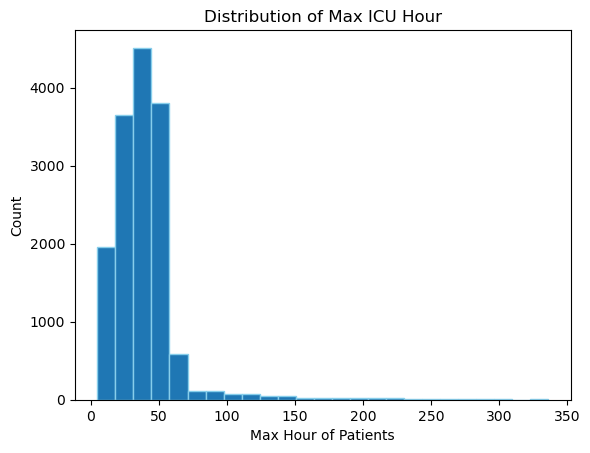

In [3]:
plt.hist(x_train.groupby(by="ID")["Hour"].apply(lambda x: max(x)), bins=25, edgecolor='skyblue')
plt.xlabel("Max Hour of Patients")
plt.ylabel("Count")
plt.title("Distribution of Max ICU Hour")
plt.savefig("ICU_hour.png", dpi=200)
plt.show()

The following number is the ratio that people have sepsis in the training set. From the result, one can find the labels are highly imbalanced. Therefore, resampling method is needed for the model.

In [4]:
y_train = pd.read_csv("train_outcome.csv")
len(y_train[y_train["Outcome"] == 1]) / len(y_train)

0.13635763338615953

In [5]:
all_x = x_train
all_y = y_train

# len(max_hour) = 15144
max_hour = np.array((), dtype="int16")
for cur_id in all_y["ID"]:
    max_hour = np.append(arr=max_hour, values=np.max(all_x[all_x["ID"] == cur_id]["Hour"]))

def pad_pack(df: pd.DataFrame, max_hour: np.ndarray, seq_len: float) -> pd.DataFrame:
    result = pd.DataFrame(np.zeros((len(max_hour) * seq_len, df.shape[1])))
    pointer = 0
    i = 0
    for hour in max_hour:
        if hour < seq_len:
            # padding
            result.iloc[(i*seq_len):(i*seq_len+hour),:] = df.iloc[pointer:(pointer+hour),:]
        else:
            # packing
            result.iloc[(i*seq_len):(i*seq_len+seq_len),:] = df.iloc[(pointer+hour-seq_len):(pointer+hour),:]
        pointer += hour
        i += 1
    return result

seq_len = 12
imputer = SimpleImputer()
scaler = StandardScaler()
pca = PCA(random_state=503)

all_x = all_x[["Hour", "Temp", "HR"]]

# impute
imputer.fit(all_x)
all_x = imputer.transform(all_x)

# padding and packing
all_x = pd.DataFrame(all_x)
all_x = pad_pack(all_x, max_hour, seq_len)

all_y = np.repeat(list(all_y["Outcome"]), seq_len)

The scatterplot indicates that a single feature cannot separate the two classes well. Thus, a more complicated model that involve interactions should be built.

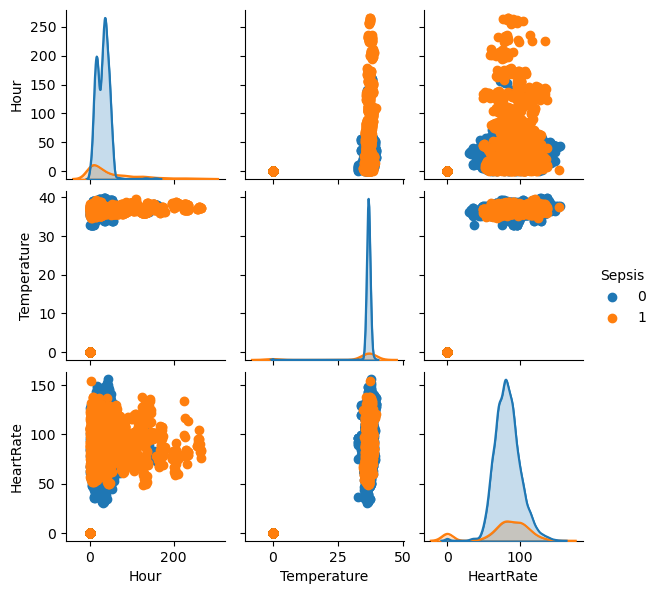

In [9]:
scatter_df = pd.concat([all_x, pd.DataFrame(all_y, columns=[3])], axis=1)
scatter_df = scatter_df.rename(columns={0: "Hour", 1: "Temperature", 2: "HeartRate", 3: "Sepsis"})
g = sns.pairplot(scatter_df.iloc[:10000, :], height=2, hue="Sepsis")
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(plt.scatter)
plt.savefig("important_features.png", dpi=200)
plt.show()

In [15]:
eda_df = all_x
eda_df["Outcome"] = all_y

The principle component plot shows that linear transformation of features cannot separate the two classes well. Thus, a more complicated model that contains nonlinear terms should be used.

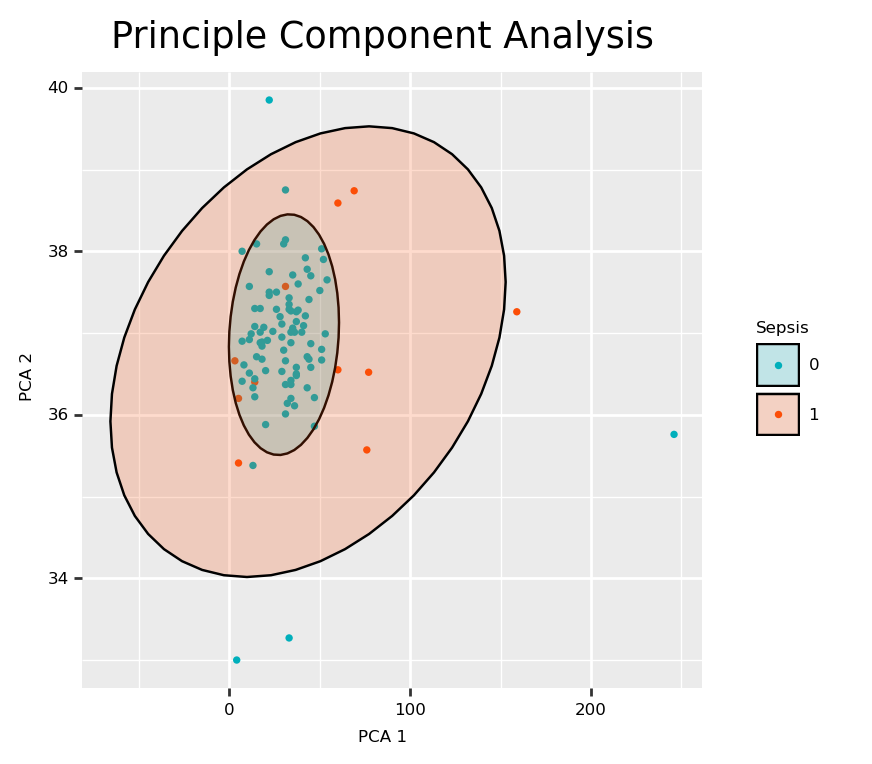

In [23]:
def choose_n_random_numbers(n):
    return np.random.randint(low=0, high=181728, size=n)

def pca_decomposition_plot(df):
    pca_plot = (
        ggplot(df, aes(df[0], df[1], fill="factor(Outcome)")) +
        geom_point(alpha=1, size=1, shape='o', color="none") +
        stat_ellipse(geom="polygon", level=0.95, alpha=0.2, color="black") +
        scale_fill_manual(values=("#00AFBB", "#FC4E07"), name="Sepsis") +
        theme(
            axis_title=element_text(size=6, face="plain", color="black"),
            axis_text=element_text(size=6, face="plain", color="black"),
            legend_title=element_text(size=6, face="plain", color="black"),
            legend_text=element_text(size=6, face="plain", color="black"),
            figure_size=(4, 4),
            dpi=200
        ) +
        labs(title="Principle Component Analysis", x="PCA 1", y="PCA 2")
    )
    print(pca_plot)

plot_idx = choose_n_random_numbers(100)
pca_decomposition_plot(eda_df.iloc[plot_idx, :])